# Sript de exploración y pruebas

Como había que entregar tanto la exploración como las pruebas en el mismo script (aunque son cosas independientes), este notebook está dividido en dos. Esta primera parte es el script de exploración y más adelante se encuentra el script pruebas, el cual es completamente independiente

1. [Script de exploración](#indice_exploracion)
2. [Script de pruebas](#indice_pruebas)

# Script de exploración<a name="indice_exploracion"></a>

### Índice  script de exploración
1. [Carga de datos](#id1)
   
2. [Exploración de las columnas DELTA y READING antes de agregar](#id2)

3. [Exploración de las series temporales tras la agragación](#id3)

In [1]:
import pandas as pd
from tqdm import tqdm
import datetime

## Carga de datos<a name="id1"></a>

Cargamos los datos y les aplicamos los siguientes pasos de preprocesado explicados en el apartado 1 del script de predicción:
- Dividimos las columnas *THOUSANDTH* entre 1000 y las agregamos a las columnas de las unidades
- Transformamos *SAMPLETIME* a tipo *datetime* y creamos una nueva columna *DATE* con la fecha únicamente

In [2]:
def get_fecha(date):
    return date.strftime("%Y-%m-%d")

def str2date(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

df = pd.read_csv('../data/Modelar_UH2022.txt',sep = '|')

df['DELTA'] = [j+(i/1000) for (j,i) in zip(df['DELTAINTEGER'].values, df['DELTATHOUSANDTH'].values)]
df['READING'] = [j+(i/1000) for (j,i) in zip(df['READINGINTEGER'].values, df['READINGTHOUSANDTH'].values)]
df.drop(['READINGINTEGER','READINGTHOUSANDTH','DELTAINTEGER','DELTATHOUSANDTH'], axis=1, inplace=True)

tqdm.pandas()
df['SAMPLETIME'] = df['SAMPLETIME'].progress_apply(str2date)
df['DATE'] = df['SAMPLETIME'].progress_apply(get_fecha)

df = df.sort_values(['ID','SAMPLETIME']).reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████| 21404828/21404828 [03:50<00:00, 92996.37it/s]


## Exploración de las columnas DELTA y READING antes de agregar<a name="id2"></a>

Sabemos que DELTA es el consumo de agua y READING es la medida acumulativa del contador, es decir, en un principio la diferencia entre dos medidas READING consecutivas del mismo contador debería ser igual a DELTA.

In [3]:
delta_equals_reading={}
for i in tqdm(df['ID'].unique()):
    one_counter_delta = df[df['ID']==i]['DELTA']
    one_counter_reading = df[df['ID']==i]['READING'].diff().fillna(0).round(4)
    delta_equals_reading[i] = sum(one_counter_delta==one_counter_reading)/len(one_counter_delta)

100%|██████████████████████████████████████████████████████████████████████████████| 2747/2747 [02:22<00:00, 19.25it/s]


En la siguiente gráfica vemos en el eje x la consistencia de los contadores, entendiendo por consistencia la proporción en que se cumple 

$DELTA=READING_{t+1}-READING_t$

es decir, si la consistencia es igual a 1 es que se cumple siempre y si es igual a 0 es que no se cumple nunca para un determinado conntador.

La conclusión es que apróximadamente 2000 contadores son consistentes y unos 700 no lo son:

<AxesSubplot:title={'center':'Counters consistency'}, ylabel='Frequency'>

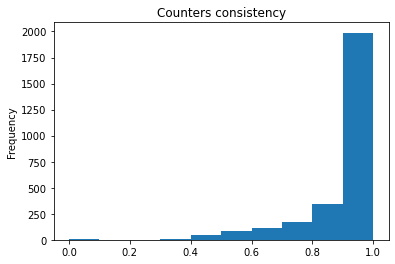

In [4]:
pd.Series(delta_equals_reading).plot(kind='hist', title='Counters consistency')

Por otro lado vamos a ver cuantos contadores tienen todas las medidas que se suponen deberían tener. El número de medidas de un contador completo debería ser $24\cdot365-1=8759$, esto es, una por hora durante un año. 

In [5]:
complete = []
len_complete = 8759
for i in tqdm(df['ID'].unique()):
    if df[df['ID']==i].shape[0] == len_complete:
        complete.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 2747/2747 [01:10<00:00, 39.19it/s]


Complete: 1970 Incomplete: 777 Total: 2747
Complete      0.717146
Incomplete    0.282854
dtype: float64


<AxesSubplot:ylabel='None'>

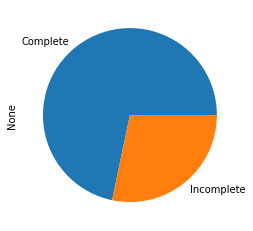

In [6]:
print('Complete:', len(complete),'Incomplete:', len(df['ID'].unique())-len(complete), 'Total:', len(df['ID'].unique())) 
complete_percentages = pd.Series({'Complete':len(complete)/len(df['ID'].unique()), 
                                  'Incomplete':1-len(complete)/len(df['ID'].unique())})
print(complete_percentages)
complete_percentages.plot(kind='pie')

Nuevamente unos 2000 contadores están completos y unos 700 les faltan medidas en mayor o menor proporción. Veamos en qué proporción les faltan medidas a los contadores incompletos en la siguiente gráfica:

100%|██████████████████████████████████████████████████████████████████████████████| 2747/2747 [01:10<00:00, 39.18it/s]

0-10% missing data      139
10-50% missing data     374
50-80% missing data     136
80-100% missing data    124
dtype: int64


<AxesSubplot:>

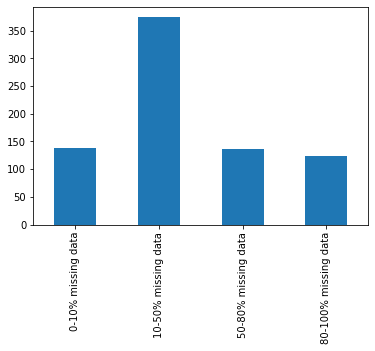

In [7]:
incompleteness = {}
len_complete = 8759
for i in tqdm(df['ID'].unique()):
    incompleteness[i] = len_complete - df[df['ID']==i].shape[0]
incompleteness_serie = pd.Series(incompleteness)
undercomplete_rate = (incompleteness_serie[incompleteness_serie>0])/len_complete
incomplete_clasif = {}
incomplete_clasif['0-10% missing data'] = len(undercomplete_rate[undercomplete_rate <= 0.1])
incomplete_clasif['10-50% missing data'] = len(undercomplete_rate[(undercomplete_rate > 0.1) & (undercomplete_rate <= 0.5)])
incomplete_clasif['50-80% missing data'] = len(undercomplete_rate[(undercomplete_rate > 0.5) & (undercomplete_rate <= 0.8)])
incomplete_clasif['80-100% missing data'] = len(undercomplete_rate[undercomplete_rate > 0.8])
incomplete_clasif = pd.Series(incomplete_clasif)
print(incomplete_clasif)
incomplete_clasif.plot(kind='bar')

Constatamos que solo unos pocos contadores tienen una cantidad de medidas incompletas significativas. Para los contadores que están incompletos pero no mucho buscaremos estrategias finas para completarlos (ver script de predicción apartado 2). En cuanto a los contadores que están muy incompletos tendremos que usar estimaciones más groseras ya que no disponemos de registros desde los que inferir las medidas que faltan.

Como curiosidad, vemos que hay 4 contadores con incompletitud negativa, es decir, tienen más medidas que una por hora. En concreto estos contadores toman 4 medidas por hora, pero esto no será un problema una vez agrupemos por días las medidas.

In [8]:
incompleteness_serie[incompleteness_serie<0]

248    -26197
292    -26295
545    -26317
1416   -26211
dtype: int64

## Exploración de las series temporales tras la agragación<a name="id3"></a>

Como adelantábamos, dado que se esperan predicciones de consumo diarias y no horarias, en algún momento habrá que agregar las medidas correspondientes a un mismo día y contador. Teniendo en cuenta la exploración hecha hasta ahora hemos agrupado las medidas. Para ver cómo las hemos agrupado ir al apartado 2 del script de predicción.

Veamos resultado tras la agregación y examinemos como han quedado las series temporales de consumos diarios en función del tipo de contador (para saber más sobre los tipos de contadores ver apartado 2.3 del script de predicción).

In [28]:
delta_df = pd.read_pickle('../data/counters_in_rows_3.pkl')

In [51]:
dicc_tipos = {'tipo_1':[], 'tipo_2':[], 'tipo_3':[], 'tipo_0':[]}

for i in tqdm(delta_df.columns):
    if delta_df[i].sum()==0:
        dicc_tipos['tipo_1'].append(i)
    elif delta_df[i][delta_df[i].index >= '2020-01-01'].isna().sum()==0:
        dicc_tipos['tipo_2'].append(i)
    elif delta_df[i][delta_df[i].index <= '2019-02-14'].isna().sum()==0:
        dicc_tipos['tipo_3'].append(i)
    else:
        dicc_tipos['tipo_0'].append(i)

dicc_num_tipos = {}
for t in dicc_tipos:
    dicc_num_tipos[t] =  len(dicc_tipos[t])
    print(t+':', len(dicc_tipos[t]))

100%|████████████████████████████████████████████████████████████████████████████| 2747/2747 [00:00<00:00, 3047.89it/s]

tipo_1: 68
tipo_2: 2535
tipo_3: 44
tipo_0: 100


En la siguiente gráfica podemos ver como la mayoría de los contadores pertenecen al **tipo 2**. Esto significa que la mayoría de contadores tienen las medidas completas al menos en Enero de 2020

<AxesSubplot:title={'center':'Tipos de contadores'}, ylabel='None'>

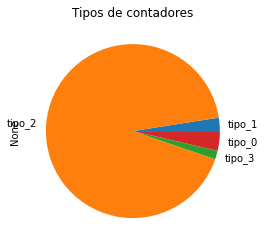

In [56]:
pd.Series(dicc_num_tipos).plot(kind='pie', title='Tipos de contadores')

**Tipo 1:** Contadores cuyas todas medidas sean 0

<AxesSubplot:>

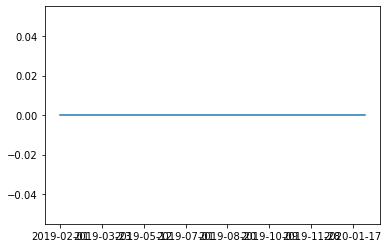

In [29]:
delta_df[dicc_tipos['tipo_1'][0]].plot()

**Tipo 2:** Contadores completos o al menos completos en Enero de 2020.

<AxesSubplot:>

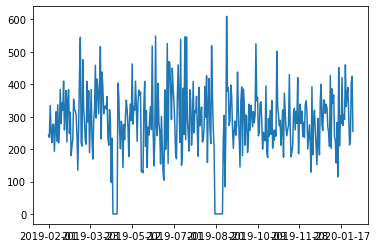

In [30]:
delta_df[dicc_tipos['tipo_2'][0]].plot()

**Tipo 3:** Contadores con Febrero de 2019 completo pero Enero de 2020 incompleto

<AxesSubplot:>

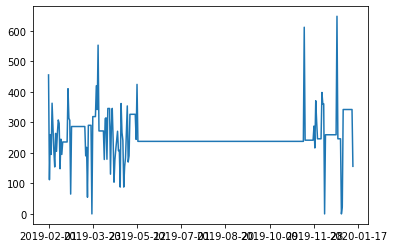

In [38]:
delta_df[dicc_tipos['tipo_3'][42]].plot()

**Tipo 4:** Contadores que ni Febrero de 2019 ni Enero de 2020 están completos

<AxesSubplot:>

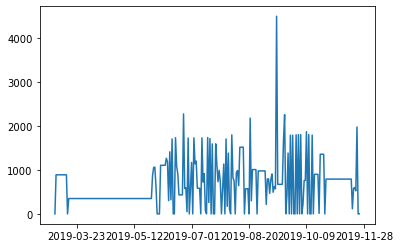

In [45]:
delta_df[dicc_tipos['tipo_0'][4]].plot()

# Script de pruebas<a name="indice_pruebas"></a>

### Índice  script de pruebas
1. [Biblioteca Prophet para series temporales](#id21)
   
2. [Modelo XGBoost con todos los contadores](#id22)

3. [Series temporales semanales para la predicción semanal](#id23)

4. [Alternativas a XGBoost](#id24)

El propósito de esta sección es explicar algunas de las principales pruebas que hemos hecho y cómo las hemos llevado a cabo. Como nos extenderíamos demasiado si explicamos todas y cada una de las alternativas que hemos explorado nos detendremos a explicar las que consideramos que eran más prometedoras pero que al final hemos descartado porque hemos obtenido mejores resultados con otros métodos. Son las 4 siguientes:

- Biblioteca Prophet para series temporales
- Modelo XGBoost con todos los contadores
- Series temporales semanales para la predicción semanal
- Alternativas a XGBoost (Gradient Boosting de scikit-learn, CatBoost, LSTM y regresiones Ridge y Lasso)

En esta sección hemos incluido poco código ya que cada prueba de las mencionadas constituye un notebook completo con un preprocesado particular de los datos para adaptarlo a esa determinada prueba etc. Todos estos notebooks están en el repositorio https://github.com/sgavela/water_footprint que haremos público tan pronto como acabe la competición. No obstante, sí que incluimos las piezas más destacadas del código de cada prueba.

Antes de continuar es necesario explicar cual ha sido nuestra metodología para probar las distintas estrategias. Sencillamente tomábamos como conjunto de test las dos últimas semanas de Enero y las sacábamos del conjunto de entrenamiento y computábamos para nuestros resultado la misma métrica que se va a usar para evaluarnos en las predicciones de las dos primeras semanas de Febrero de 2020.

Bien es cierto que hay una pequeña trampa, y es que algunos de los valores faltantes los hemos completado nosotros mismos y por tanto a veces estábamos tratando de predecir consumos que nosotros mismos habíamos completado (y obviamente los habíamos completado siguiendo las mismas normas en train y test), por lo que los resultados de nuestros test estaban algo adulterados y éramos conscientes de que las métricas iban a empeorar cuando intentásemos predecir consumos desconocidos.

### Biblioteca Prophet para series temporales<a name="id21"></a>

Teníamos claro que una de las alternativas que había que probar era usar modelos enfocados a series temporales. En este punto nos debatimos entre la biblioteca Prophet de Facebook y los modelos AutoARIMA. Ambos son modelos ampliamente utilizados para predicción de series temporales. Tras probar ambos nos decantamos por Auto ARIMA porque ofreció mejores métricas. En cuanto a la implementación es muy similar a la implementación de AutoARIMA del apartado 4.1 del script de predicción: para cada contador adaptamos la Serie de pandas al formato que requiere Prophet, entrenamos el modelo y predecimos.

In [ ]:
results_dict = {}
for i in tqdm(train['ID'].unique()):
    one_counter_train = train_and_test[train_and_test['ID']==i]
    one_counter_train.drop('ID', axis=1, inplace=True)
    one_counter_train.rename(columns = {'DATE':'ds', 'DELTA':'y'}, inplace = True)
    model = Prophet(yearly_seasonality=False, daily_seasonality=False)
    model.fit(one_counter_train)
    future = model.make_future_dataframe(periods=14)
    forecast = model.predict(future)
    results_dict[i] = forecast['yhat'].tail(14)

### Modelo XGBoost con todos los contadores<a name="id22"></a>

Uno de los modelos que finalmente hemos usado ha sido XGBoost. Concretamente hemos entrenado un modelo XGBoost para cada contador con los datos únicamente de ese contador. Pero esta no ha sido la única alternativa que hemos barajado. De hecho, en la entrega de la fase local optamos por un único modelo XGBoost que se entrenaba con los datos de todos los contadores a la vez. 

Para ello, además de las variables temporales y climatológicas que están detalladas en el apartado 4.2 del script de predicción, incluíamos algunas variables propias de cada contador como el ID, el consumo medio o la varianza del consumo. Al final y a la vista de nuestros resultados, nos decantamos por XGBoosts individuales para los contadores. Aún así el XGBoost global nos permitió superar la fase local a tan solo 700 puntos de error del primer clasificado por lo que fue una alternativa que nos costó descartar.

La implementación es similar al XGBoost del apartado 4.2 del script de predicción pero incluyendo las variables que distinguían los contadores entre sí y sin necesidad de un bucle que itere sobre los índices de los contadores ya que se entrena un único modelo.

In [ ]:
ID = []
DELTA = []
DATE = []
MEAN_CONSUMPTION = []
VARIANCE_CONSUMPTION = []
for i in tqdm(df4.T.columns):
    ID += [i for j in range(365)]
    DELTA += list(df4.T[i].values)
    DATE += all_dates
    MEAN_CONSUMPTION += [mean_consumption[i] for j in range(365)]
    VARIANCE_CONSUMPTION += [variance_consumption[i] for j in range(365)]

### Series temporales para la predicción semanal<a name="id23"></a>

Otra estrategia que barajamos y que tiene bastante lógica fue hacer un modelo independiente para la predicción agregada semanal. Es decir, en lugar de hacer predicciones diarias para los 14 primeros días de febrero y posteriormente sumar los consumos semanales para dar una predicción semanal, directamente agregar los consumos por semanas en la serie temporal y entrenar un modelo distinto. Esta idea aparentemente buena nos dio peores resultados que hacer predicciones diarias. Aunque desconocemos el motivo, suponemos que puede deberse a que así como hay suficientes días para entrenar modelos en la mayoría de los modelos, puede que no haya suficientes semanas completas.

En cuanto a la implementación el paso clave aquí fue agregar los consumos por semanas, luego sencillamente probamos AutoARIMA, Prophet y XGBoost (agregando variables como la media de temperatura de esa semana o el número de semana del año en el que nos encontrábamos).

In [ ]:
week_train = week_train.groupby(['YEAR_WEEK','ID']).agg({ 
                                     'DELTA':sum,
                                     'PRECIPITATIONS':np.mean,
                                     'MIN_TEMP':min,
                                     'MEAN_TEMP':np.mean,
                                     'MAX_TEMP':max,
                                     'SUN':np.mean,
                                     'MEAN_CONSUMPTION':np.mean,
                                     'VARIANCE_CONSUMPTION':np.mean}).reset_index()

weeks_in_a_year = 52
week_train['sin_YEAR_WEEK'] = np.sin(2*np.pi*week_train['YEAR_WEEK']/weeks_in_a_year)
week_train['cos_YEAR_WEEK'] = np.cos(2*np.pi*week_train['YEAR_WEEK']/weeks_in_a_year) 
week_train.head()

### Alternativas a XGBoost<a name="id24"></a>

Hasta ahora, además de los modelos para series temporales AutoARIMA y Prophet, únicamente hemos mencionado un modelo de regresión: XGBoost. Por supuesto, no hemos escogido este modelo al azar sino que tanto para el modelo global que presentamos en la primera fase como para los modelos por contadores individuales que estamos presentando en la entrega definitiva, hemos probado diversos modelos de regresión. Entre otros las regresiones Ridge y Lasso, Gradient Boosting (similar a XGBoost pero incluido en scikit-learn), CatBoost (https://catboost.ai/) y LSTMs que implementamos en Tensorflow con una ventana deslizante que iba recorriendo los días de 7 en 7 y trataba de predecir el octavo día (https://www.tensorflow.org/tutorials/structured_data/time_series).